In [5]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACE_API_KEY'] = os.getenv('HUGGINGFACE_API_KEY')

In [83]:
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

In [11]:
model = ChatGroq(model_name="moonshotai/kimi-k2-instruct-0905")
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [55]:
def call_model(state: MessagesState):
    messages = state["messages"]
    print(f"this is my current message: {messages}")
    response = model.invoke(messages)
    return {"messages": [response]}

### this code is for testing

In [56]:
state = {"messages": ["Hi"]}
call_model(state)["messages"][0].content

this is my current message: ['Hi']


'Hi there! What can I help you with today?'

In [57]:
workflow = StateGraph(MessagesState)

In [58]:
workflow.add_node("mybot", call_model)


In [59]:
workflow.add_edge(START, "mybot")

In [60]:
workflow.add_edge("mybot", END)

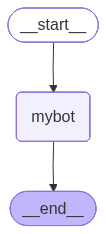

In [61]:
workflow.compile()

In [62]:
app = workflow.compile()

In [63]:
input = {"messages": ["Who is the president of the United States?"]}

In [64]:
app.invoke(input)

this is my current message: [HumanMessage(content='Who is the president of the United States?', additional_kwargs={}, response_metadata={}, id='6feb6bab-78ae-4fd8-a83f-2c123a1fdebb')]


{'messages': [HumanMessage(content='Who is the president of the United States?', additional_kwargs={}, response_metadata={}, id='6feb6bab-78ae-4fd8-a83f-2c123a1fdebb'),
  AIMessage(content='As of my last knowledge update in July 2024, the President of the United States is **Joe Biden**. He has been serving as the 46th president since January 20, 2021. The next presidential election is scheduled for November 2024, with the winner taking office in January 2025. For developments beyond July 2024, I recommend checking the latest, reliable news sources.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 35, 'total_tokens': 119, 'completion_time': 0.233317327, 'completion_tokens_details': None, 'prompt_time': 0.010232448, 'prompt_tokens_details': None, 'queue_time': 0.285773589, 'total_time': 0.243549775}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'st

### Custom tool

In [101]:
@tool
def search(query: str):
    """this is my custom tool for searching a weather in a city"""
    if "delhi" in query.lower():
        return "the weather in delhi is 25 degrees celsius"
    return "i am not sure about the weather in that city"

In [102]:
search.invoke("what is the weather in bangalore?")

'i am not sure about the weather in that city'

In [103]:
search

StructuredTool(name='search', description='this is my custom tool for searching a weather in a city', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001F101142CA0>)

In [104]:
tools = [search]

In [105]:
llm_with_tools = model.bind_tools(tools)

In [106]:
response = llm_with_tools.invoke("what is the weather in delhi?")

In [107]:
response.content

''

In [108]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'functions.search:0',
  'type': 'tool_call'}]

In [109]:
def call_model(state: MessagesState):
    question = state["messages"]
    response = llm_with_tools.invoke(question) 
    return {"messages": [response]}


In [120]:
def router(state: MessagesState):
    message = state["messages"]
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [121]:
tool_node = ToolNode(tools)

In [122]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool for searching a weather in a city', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001F101142CA0>)}, _injected_args={'search': _InjectedArgs(state={}, store=None, runtime=None)}, _handle_tool_errors=<function _default_handle_tool_errors at 0x000001F1010E0EA0>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)

In [123]:
workflow2 = StateGraph(MessagesState)

In [124]:
workflow2.add_node("llm_with_tools", call_model)

In [125]:
workflow2.add_node("mytools", tool_node)

In [126]:
workflow2.add_edge(START, "llm_with_tools")
workflow2.add_conditional_edges(
    "llm_with_tools",
    router,
    {
        "tools": "mytools",
        END : END
    }
    
)

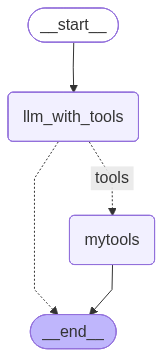

In [127]:
workflow2.compile()

In [128]:
app = workflow2.compile()

In [132]:
app.invoke({"messages": ["who is elon musk?"]})

{'messages': [HumanMessage(content='who is elon musk?', additional_kwargs={}, response_metadata={}, id='1da89a0a-5ff8-48cf-ac3d-abb8539836b0'),
  AIMessage(content='Elon Musk is a South-African-born American entrepreneur and engineer who has founded or led several of the most influential technology companies of the 21st century.\n\nKey companies and roles:\n\n- Tesla, Inc. – CEO since 2008. Tesla designs and manufactures electric vehicles, energy-storage systems, and solar products and has become the world’s most valuable automaker by market capitalization.\n\n- SpaceX – Founder, CEO and chief engineer (2002). SpaceX builds reusable orbital rockets and spacecraft; its Falcon 9 and Starship vehicles supply the International Space Station and deploy commercial satellites.\n\n- X Corp. (formerly Twitter) – Owner and chairman (2022). After purchasing Twitter for about $44 billion, Musk rebranded it “X” and overhauled its operations and content-moderation policies.\n\n- Neuralink – Co-found

In [133]:
app.invoke({"messages": ["what is weather in delhi?"]})

{'messages': [HumanMessage(content='what is weather in delhi?', additional_kwargs={}, response_metadata={}, id='e7808990-4c4a-4e61-b332-76f4fb533918'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'functions.search:0', 'function': {'arguments': '{"query":"weather in delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 101, 'total_tokens': 120, 'completion_time': 0.061351743, 'completion_tokens_details': None, 'prompt_time': 0.043837448, 'prompt_tokens_details': None, 'queue_time': 0.283820912, 'total_time': 0.105189191}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c18e1-1b69-7c30-a0f8-74ec345daad0-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in delhi'}, 'id': 'functions.search:0', 'type': 'tool_call'}], invalid_t

In [134]:
app.invoke({"messages": ["what is weather in Bangalore?"]})

{'messages': [HumanMessage(content='what is weather in Bangalore?', additional_kwargs={}, response_metadata={}, id='273722bd-3438-45b1-93cc-cfae9b492dfd'),
  AIMessage(content="I'll check the weather for Bangalore.", additional_kwargs={'tool_calls': [{'id': 'functions.search:0', 'function': {'arguments': '{"query":"weather in Bangalore"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 100, 'total_tokens': 125, 'completion_time': 0.094985001, 'completion_tokens_details': None, 'prompt_time': 0.01559568, 'prompt_tokens_details': None, 'queue_time': 0.283621956, 'total_time': 0.110580681}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c18e1-4c20-75b0-ac9c-8afc07852ed5-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Bangalore'}, 'id': 'funct